# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


In [1]:
import os
import re
import emoji
import pandas as pd
import nltk
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0.0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        token_counts = Counter(tokens)
        most_common_tokens = token_counts.most_common(num_tokens)
        print(f"\nMost common tokens:")
        for token, count in most_common_tokens[:5]:
            print(f"{token}: {count} times")

    return([num_tokens, num_unique_tokens, lexical_diversity, num_characters])
    

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return re.findall(r'\S+', text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
data_location = "/Users/Chris/Downloads/M1 Results/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [6]:
twitter_data = twitter_data[['artist', 'description']]
twitter_data.head()

,artist,description
0,cher,NaN
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...


In [7]:
# Read in the lyrics
def lyrics_dictionary(folder_path):
    lyrics_dict = {}

    # Iterate through all subdirectories and files
    for root, _, files in os.walk(folder_path):
        for filename in files:
            file_path = os.path.join(root, filename)

            # Checks whether the file_path points to a valid file (not a directory)
            if os.path.isfile(file_path):

                with open(file_path, "r") as file:
                    lines = file.readlines()
                    
                    # Checks if the lines list is not empty
                    if lines:
                        # Extracts the title
                        title = lines[0].strip() 

                        # Combine the lines stored as the lyrics
                        lyrics = ''.join(lines[1:])

                        # Extract artist name from the folder
                        artist = os.path.basename(root)

                        # Add the song lyrics to the artist's dictionary with the title as the inner key
                        if artist not in lyrics_dict:
                            lyrics_dict[artist] = {}
                        lyrics_dict[artist][title] = lyrics

    return lyrics_dict

# Get the lyrics folder path
lyrics_folder_path = lyrics_dictionary(lyrics_folder)

# List of dictionaries for dataframe
rows = [
    {'artist': artist, 'song': song.replace('"', ''), 'lyrics': lyrics.replace('\n', ' ')}
    for artist, songs in lyrics_folder_path.items()
    for song, lyrics in songs.items()
]

# Create the dataframe
lyrics_data = pd.DataFrame(rows, columns = ['artist', 'song', 'lyrics'])
lyrics_data.head()

,artist,song,lyrics
0,cher,88 Degrees,"Stuck in L.A., ain't got no friends And so..."
1,cher,A Different Kind Of Love Song,What if the world was crazy and I was sane ...
2,cher,After All,"Well, here we are again I guess it must be ..."
3,cher,Again,Again evening finds me at your door Here t...
4,cher,Alfie,"What's it all about, Alfie? Is it just for ..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3626426,cher,Pronouns: He/Him/His | Flight Attendant with D...,"[pronouns, hehimhis, flight, attendant, with, ..."
746985,cher,Keulthieu 🤤❤️,"[keulthieu, 🤤❤️]"
115244,cher,Cancer♋️ Free-State📍 IGhttp://instagram.com/sc...,"[cancer♋️, freestate📍, ighttpinstagramcomscarl..."
2363886,cher,👩🏻‍🍳Freelancer Chef de Cocina 🌎 Consultoría pa...,"[👩🏻‍🍳freelancer, chef, de, cocina, 🌎, consulto..."
1443673,cher,♎️ RN. Isaiah’s mom,"[♎️, rn, isaiah’s, mom]"
3844974,cher,"📚un libro mi primera opción 😊🧠📚♥️🐷🐾 , irrevere...","[📚un, libro, mi, primera, opción, 😊🧠📚♥️🐷🐾, irr..."
1740323,cher,"se quer que eu siga de volta, avisa. vlw flw! ❤","[se, quer, que, eu, siga, de, volta, avisa, vl..."
2627295,cher,"I am woman, a human, being. 💖","[i, am, woman, a, human, being, 💖]"
101344,cher,👩‍👧‍👦🇺🇸🇬🇧💰🐝,[👩‍👧‍👦🇺🇸🇬🇧💰🐝]
2761759,cher,♥ soy una niña muy talentosa ♥,"[♥, soy, una, niña, muy, talentosa, ♥]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area of improvement for tokenization could be handling special characters and emojis. Frequently, individuals omit spacing between their text and emojis. Given that our current tokenization strategy relies on whitespace, this can lead to the text and emojis as a single token. An improvement could be tokenization that distinguishes between text and emojis by considering the presence of emojis as a separation point.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
artist_list = ['cher', 'robyn']

# Function to count words and filter stopwords
def count_words(tokens):
    # Filter stopwords from the list of tokens
    filtered_tokens = [token for token in tokens if token.lower() not in sw]

    # Count the tokens
    token_counts = Counter(filtered_tokens)
    return token_counts

# Function to display top words
def display_top_words(token_counts, top_n = 10):
    top_words = token_counts.most_common(top_n)
    for word, count in top_words:
        print(f'{word}: {count}')

# Calculate and display descriptive statistics for lyrics data of each artist
for artist_name in artist_list:
    artist_lyrics = lyrics_data.loc[lyrics_data['artist'] == artist_name, 'tokens'].explode().tolist()
    
    # Count words in the lyrics data
    artist_token_counts = count_words(artist_lyrics)
    
    # Calculate and display descriptive statistics
    print(f'\n{artist_name} lyrics descriptive statistics:')
    print(descriptive_stats(artist_lyrics))
    
    # Display top words
    print(f'\nTop words in {artist_name} lyrics:')
    display_top_words(artist_token_counts)


cher lyrics descriptive statistics:
There are 68205 tokens in the data.
There are 3805 unique tokens in the data.
There are 257810 characters in the data.
The lexical diversity is 0.056 in the data.

Most common tokens:
you: 2726 times
i: 2626 times
the: 2374 times
to: 1643 times
and: 1540 times
[68205, 3805, 0.05578769884905799, 257810]

Top words in cher lyrics:
love: 917
im: 510
know: 473
dont: 428
youre: 331
baby: 314
time: 313
see: 306
oh: 296
one: 275

robyn lyrics descriptive statistics:
There are 24952 tokens in the data.
There are 2253 unique tokens in the data.
There are 95782 characters in the data.
The lexical diversity is 0.090 in the data.

Most common tokens:
you: 1303 times
i: 757 times
the: 718 times
me: 563 times
to: 544 times
[24952, 2253, 0.09029336325745431, 95782]

Top words in robyn lyrics:
im: 255
dont: 252
love: 238
know: 237
got: 230
baby: 211
like: 203
never: 143
youre: 142
get: 130


Q: what observations do you make about these data? 

A: Cher's lyrics have more tokens and characters but lower lexical diversity compared to Robyn's lyrics. Robyn's lyrics, on the other hand, have fewer tokens and characters but exhibit higher lexical diversity. The most common tokens for both artists are similar, reflecting common words used in their lyrics.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

### Lyrics

In [12]:
# Create separate dataframes for each artist's lyrics
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']

# Calculate concentration and filter tokens for lyrics
def calculate_lyrics_concentration(tokens):
    token_counts = Counter(tokens)
    concentration = [count / len(tokens) for count in token_counts.values()]
    return token_counts, concentration

# Calculate token counts and concentration for each artist's lyrics
cher_lyrics_token_counts, cher_lyrics_concentration = calculate_lyrics_concentration(cher_lyrics['tokens'].explode().tolist())
robyn_lyrics_token_counts, robyn_lyrics_concentration = calculate_lyrics_concentration(robyn_lyrics['tokens'].explode().tolist())

# Create dataframes for token statistics for lyrics
cher_lyrics_df = pd.DataFrame({'Token': cher_lyrics_token_counts.keys(), 'Cher Count': cher_lyrics_token_counts.values(), 'Cher Concentration': cher_lyrics_concentration})
robyn_lyrics_df = pd.DataFrame({'Token': robyn_lyrics_token_counts.keys(), 'Robyn Count': robyn_lyrics_token_counts.values(), 'Robyn Concentration': robyn_lyrics_concentration})

# Merge the two dataframes on 'Token' for lyrics
merged_lyrics_df = cher_lyrics_df.merge(robyn_lyrics_df, on='Token', how='inner')

# Calculate the concentration ratio for lyrics
merged_lyrics_df['Concentration Ratio'] = merged_lyrics_df['Cher Concentration'] / merged_lyrics_df['Robyn Concentration']

# Filter tokens based on count in both lyrics corpora
final_lyrics_df = merged_lyrics_df[(merged_lyrics_df['Cher Count'] >= 5) & (merged_lyrics_df['Robyn Count'] >= 5)]

#### Top 10 Unique Tokens in Cher's Lyrics

In [13]:
final_lyrics_df.sort_values('Concentration Ratio', ascending = False)[0:10]

,Token,Cher Count,Cher Concentration,Robyn Count,Robyn Concentration,Concentration Ratio
228,walk,114,0.001671,5,0.000200,8.341113
232,find,134,0.001965,6,0.000240,8.170388
344,enough,123,0.001803,6,0.000240,7.499685
333,man,201,0.002947,10,0.000401,7.353349
97,believe,139,0.002038,7,0.000281,7.264503
220,without,84,0.001232,5,0.000200,6.146083
209,strong,75,0.001100,5,0.000200,5.487574
357,home,102,0.001495,7,0.000281,5.330786
19,live,68,0.000997,5,0.000200,4.975401
329,tears,56,0.000821,5,0.000200,4.097389


#### Top 10 Unique Tokens in Robyn's Lyrics

In [14]:
final_lyrics_df.sort_values('Concentration Ratio', ascending = True)[0:10]

,Token,Cher Count,Cher Concentration,Robyn Count,Robyn Concentration,Concentration Ratio
83,work,15,0.000220,74,0.002966,0.074156
259,beat,17,0.000249,77,0.003086,0.080769
645,yourself,10,0.000147,32,0.001282,0.114324
369,dance,25,0.000367,78,0.003126,0.117256
878,alright,10,0.000147,30,0.001202,0.121946
565,hang,8,0.000117,24,0.000962,0.121946
1000,forgive,5,0.000073,15,0.000601,0.121946
1001,shake,6,0.000088,18,0.000721,0.121946
129,between,8,0.000117,23,0.000922,0.127248
42,88,5,0.000073,13,0.000521,0.140707


### Tweets

In [15]:
# Create separate dataframes for each artist's tweets
cher_tweets = twitter_data[twitter_data['artist'] == 'cher']
robyn_tweets = twitter_data[twitter_data['artist'] == 'robyn']

# Calculate concentration and filter tokens for tweets
def calculate_tweets_concentration(tokens):
    token_counts = Counter(tokens)
    concentration = [count / len(tokens) for count in token_counts.values()]
    return token_counts, concentration

# Calculate token counts and concentration for each artist's tweets
cher_tweets_token_counts, cher_tweets_concentration = calculate_tweets_concentration(cher_tweets['tokens'].explode().tolist())
robyn_tweets_token_counts, robyn_tweets_concentration = calculate_tweets_concentration(robyn_tweets['tokens'].explode().tolist())

# Create dataframes for token statistics for tweets
cher_tweets_df = pd.DataFrame({'Token': cher_tweets_token_counts.keys(), 'Cher Count': cher_tweets_token_counts.values(), 'Cher Concentration': cher_tweets_concentration})
robyn_tweets_df = pd.DataFrame({'Token': robyn_tweets_token_counts.keys(), 'Robyn Count': robyn_tweets_token_counts.values(), 'Robyn Concentration': robyn_tweets_concentration})

# Merge the two dataframes on 'Token' for tweets
merged_tweets_df = cher_tweets_df.merge(robyn_tweets_df, on='Token', how='inner')

# Calculate the concentration ratio for tweets
merged_tweets_df['Concentration Ratio'] = merged_tweets_df['Cher Concentration'] / merged_tweets_df['Robyn Concentration']

# Filter tokens based on count in both tweets corpora
final_tweets_df = merged_tweets_df[(merged_tweets_df['Cher Count'] >= 5) & (merged_tweets_df['Robyn Count'] >= 5)]

#### Top 10 Unique Tokens in Cher's Tweets

In [16]:
final_tweets_df.sort_values('Concentration Ratio', ascending = False)[0:10]

,Token,Cher Count,Cher Concentration,Robyn Count,Robyn Concentration,Concentration Ratio
393,grandmother,7132,0.000299,19,0.000009,33.765104
1059,#fbr,3131,0.000131,12,0.000006,23.469951
812,resister,1817,0.000076,7,0.000003,23.348944
947,#resister,1276,0.000053,5,0.000002,22.955726
876,nana,2010,0.000084,8,0.000004,22.600416
25118,rbsoul,1530,0.000064,7,0.000003,19.660916
336,grandma,5705,0.000239,27,0.000013,19.006504
33,#theresistance,3211,0.000135,16,0.000007,18.052223
21680,hiphoprap,2479,0.000104,13,0.000006,17.153136
2516,gop,1288,0.000054,7,0.000003,16.551150


#### Top 10 Unique Tokens in Robyn's Tweets

In [17]:
final_tweets_df.sort_values('Concentration Ratio', ascending = True)[0:10]

,Token,Cher Count,Cher Concentration,Robyn Count,Robyn Concentration,Concentration Ratio
77885,vänner,5,2.096011e-07,138,0.000064,0.003259
93235,bäst,5,2.096011e-07,99,0.000046,0.004543
63688,sveriges,15,6.288033e-07,294,0.000137,0.004589
40846,träning,6,2.515213e-07,115,0.000054,0.004693
68353,brinner,7,2.934415e-07,131,0.000061,0.004807
14142,följ,12,5.030426e-07,221,0.000103,0.004884
46862,gärna,11,4.611224e-07,202,0.000094,0.004898
77088,arbetar,11,4.611224e-07,194,0.000090,0.005100
69081,varje,6,2.515213e-07,104,0.000048,0.005190
20182,familj,6,2.515213e-07,102,0.000048,0.005291


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: As for the lyrics data, Cher tends to convey a more sentimental tone with words such as `believe`, `strong`, and `tears` whereas Robyn's music appears to have a more upbeat and party-oriented vibe with words such as `beat`, `dance`, and `shake`. Cher's tweets predominantly feature complete English words and hashtags, whereas Robyn's tweets include Swedish words.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [18]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

### Lyrics

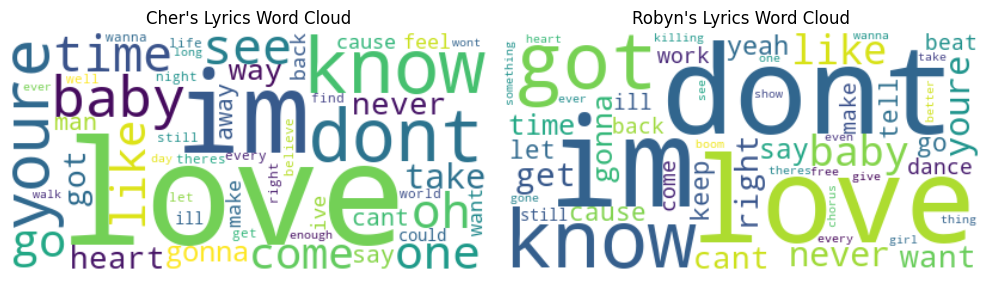

In [19]:
# Function to count words and filter stopwords
def count_words(tokens, min_freq = 2):
    # Count the tokens
    counter = Counter(tokens)
    
    # Filter tokens based on minimum frequency
    filtered_counter = {token: count for token, count in counter.items() if count >= min_freq}
    return filtered_counter

# Filter lyrics data by artist
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']

# Tokenize and filter stopwords
cher_lyrics_tokens = cher_lyrics['tokens'].explode().tolist()
cher_lyrics_tokens = [word for word in cher_lyrics_tokens if word.lower() not in sw]
robyn_lyrics_tokens = robyn_lyrics['tokens'].explode().tolist()
robyn_lyrics_tokens = [word for word in robyn_lyrics_tokens if word.lower() not in sw]

# Count words in filtered lyrics data with a minimum frequency of 5
cher_word_freq = count_words(cher_lyrics_tokens, min_freq = 5)
robyn_word_freq = count_words(robyn_lyrics_tokens, min_freq = 5)

# Initialize word cloud for each artist
cher_wc_instance = WordCloud(background_color = 'white', max_words = 50)
robyn_wc_instance = WordCloud(background_color = 'white', max_words = 50)

# Generate word cloud word frequencies
cher_wordcloud_image = cher_wc_instance.generate_from_frequencies(cher_word_freq)
robyn_wordcloud_image = robyn_wc_instance.generate_from_frequencies(robyn_word_freq)

# Create subplots for side-by-side display
plt.figure(figsize = (10, 5))

# Plot Cher's word cloud on the left
plt.subplot(1, 2, 1)
plt.imshow(cher_wordcloud_image, interpolation = 'bilinear')
plt.title("Cher's Lyrics Word Cloud")
plt.axis('off')

# Plot Robyn's word cloud on the right
plt.subplot(1, 2, 2)
plt.imshow(robyn_wordcloud_image, interpolation = 'bilinear')
plt.title("Robyn's Lyrics Word Cloud")
plt.axis('off')

# Show the side-by-side plots
plt.tight_layout()
plt.show()

### Tweets

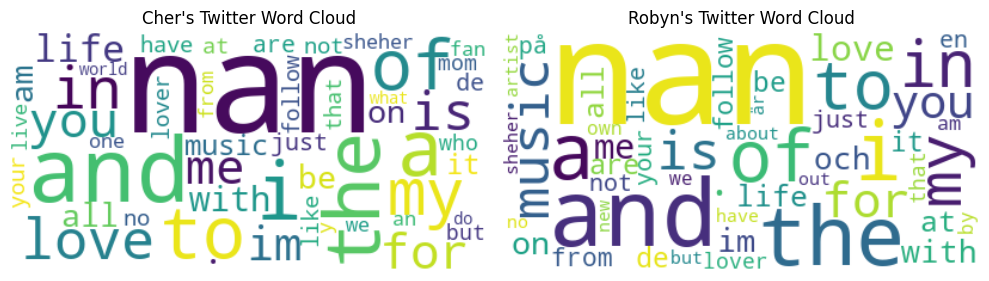

In [20]:
# Filter Twitter data by artist
cher_twitter = twitter_data[twitter_data['artist'] == 'cher']
robyn_twitter = twitter_data[twitter_data['artist'] == 'robyn']

# Function to count words and filter stopwords
def count_words(tokens, min_freq = 5):
    # Tokenize and flatten the list of tokens
    tokens = tokens.explode().tolist()
    
    # Count the tokens
    token_counts = Counter(tokens)
    
    # Filter tokens based on minimum frequency
    filtered_counts = {token: count for token, count in token_counts.items() if count >= min_freq}
    return filtered_counts

# Count words with a minimum frequency of 5
cher_word_freq = count_words(cher_twitter['tokens'], min_freq = 5)
robyn_word_freq = count_words(robyn_twitter['tokens'], min_freq = 5)

# Initialize word cloud
cher_wc_instance = WordCloud(background_color='white', max_words = 50)
robyn_wc_instance = WordCloud(background_color='white', max_words = 50)

# Generate the word cloud from word frequencies
cher_wordcloud_image = cher_wc_instance.generate_from_frequencies(cher_word_freq)
robyn_wordcloud_image = robyn_wc_instance.generate_from_frequencies(robyn_word_freq)

# Create subplots for side-by-side display
plt.figure(figsize = (10, 5))

# Plot Cher's word cloud on the left
plt.subplot(1, 2, 1)
plt.imshow(cher_wordcloud_image, interpolation = 'bilinear')
plt.title("Cher's Twitter Word Cloud")
plt.axis('off')

# Plot Robyn's word cloud on the right
plt.subplot(1, 2, 2)
plt.imshow(robyn_wordcloud_image, interpolation = 'bilinear')
plt.title("Robyn's Twitter Word Cloud")
plt.axis('off')

# Show the side-by-side plots
plt.tight_layout()
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: In the word cloud representing lyrics, Cher and Robyn have certain common terms like `love` and `time`. However, there are distinctions between them. For example, the word `baby` prominently features in Cher's lyrics but is not apparent in Robyn's. In the Twitter word cloud, both Cher and Robyn share common terms like `love` and `music`.